# Lab 4

## Part 1: AE and VAE

In [1]:
# Import dataset and split
import torch, torchvision
numb_batch = 64

T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

100%|██████████| 9912422/9912422 [00:00<00:00, 469707743.91it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110828631.13it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 201859005.77it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8075679.85it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [2]:
# Import libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

In [3]:
# Define the architecture of the autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)  # Latent space representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output is normalized between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
latent_dim = 2

In [5]:
# Initialize the model, loss function, and optimizer
model_ae = Autoencoder()
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(model_ae.parameters(), lr=learning_rate)

In [6]:
# Lists to store losses during training
autoencoder_losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_dl:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images
        optimizer_ae.zero_grad()
        outputs = model_ae(inputs)
        loss = criterion_ae(outputs, inputs)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dl.dataset)
    autoencoder_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0622
Epoch [2/10], Loss: 0.0477
Epoch [3/10], Loss: 0.0405
Epoch [4/10], Loss: 0.0382
Epoch [5/10], Loss: 0.0369
Epoch [6/10], Loss: 0.0361
Epoch [7/10], Loss: 0.0354
Epoch [8/10], Loss: 0.0349
Epoch [9/10], Loss: 0.0344
Epoch [10/10], Loss: 0.0340


In [7]:
# Define the architecture of the Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [8]:
# Initialize the VAE model, loss function, and optimizer
model_vae = VAE(latent_dim)
criterion_vae = nn.BCELoss(reduction='sum')  # Binary Cross Entropy Loss for binary data
optimizer_vae = optim.Adam(model_vae.parameters(), lr=learning_rate)

In [9]:
# Lists to store losses and KL divergences during training
vae_losses = []
kl_divergences = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    running_kld = 0.0
    for data in train_dl:
        inputs, _ = data
        optimizer_vae.zero_grad()
        recon_batch, mu, logvar = model_vae(inputs)
        BCE = criterion_vae(recon_batch, inputs.view(-1, 28 * 28))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KLD
        loss.backward()
        optimizer_vae.step()
        running_loss += loss.item()
        running_kld += KLD.item()
    epoch_loss = running_loss / len(train_dl.dataset)
    epoch_kld = running_kld / len(train_dl.dataset)
    vae_losses.append(epoch_loss)
    kl_divergences.append(epoch_kld)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, KL Divergence: {epoch_kld:.4f}")


Epoch [1/10], Loss: 182.3867, KL Divergence: 3.5101
Epoch [2/10], Loss: 156.7091, KL Divergence: 5.4887
Epoch [3/10], Loss: 151.0571, KL Divergence: 5.8975
Epoch [4/10], Loss: 148.0613, KL Divergence: 6.1289
Epoch [5/10], Loss: 145.9306, KL Divergence: 6.2709
Epoch [6/10], Loss: 145.0816, KL Divergence: 6.3461
Epoch [7/10], Loss: 144.2266, KL Divergence: 6.4095
Epoch [8/10], Loss: 142.5919, KL Divergence: 6.5078
Epoch [9/10], Loss: 142.0372, KL Divergence: 6.5606
Epoch [10/10], Loss: 141.6575, KL Divergence: 6.6211


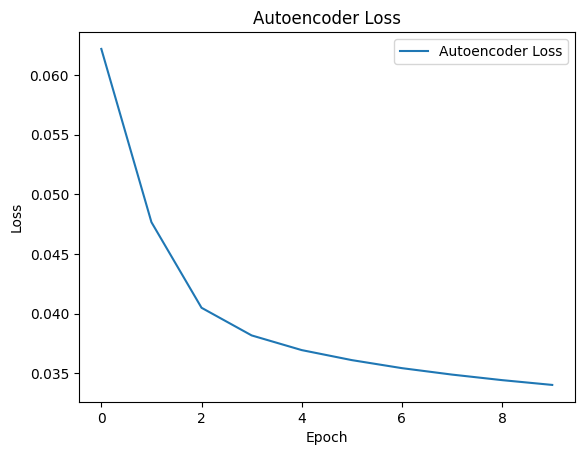

In [10]:
import matplotlib.pyplot as plt

# Plot losses for Autoencoder
plt.plot(autoencoder_losses, label="Autoencoder Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Autoencoder Loss")
plt.show()

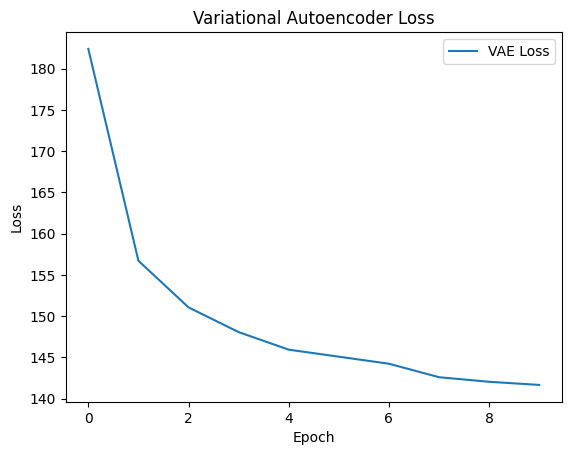

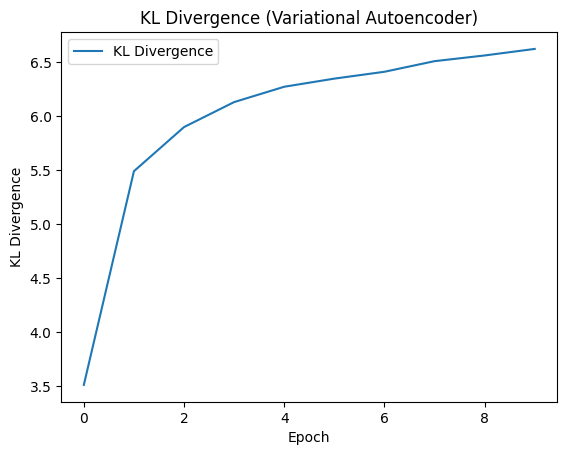

In [11]:
# Plot losses for Variational Autoencoder
plt.plot(vae_losses, label="VAE Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Variational Autoencoder Loss")
plt.show()

# Plot KL divergence for Variational Autoencoder
plt.plot(kl_divergences, label="KL Divergence")
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title("KL Divergence (Variational Autoencoder)")
plt.show()

### Comment

#### **Autoencoder (AE) plot**

The plot shows the decrease in loss with each epoch during the training of the Autoencoder. This is indicative of the model's ability to reconstruct the input images accurately over successive epochs, as the loss decreases with training

#### **Variational Autoencoder (VAE) plot**

The plot illustrates two trends during the training of the Variational Autoencoder. Firstly, similar to the Autoencoder, there is a decrease in the reconstruction loss (VAE Loss) with each epoch, indicating improved reconstruction performance over time. Secondly, the plot also shows an increase in the KL Divergence with each epoch. This divergence term measures the discrepancy between the learned latent distribution and the prior distribution, and its increase suggests that the learned latent space is becoming more distinct from the prior distribution as training progresses.

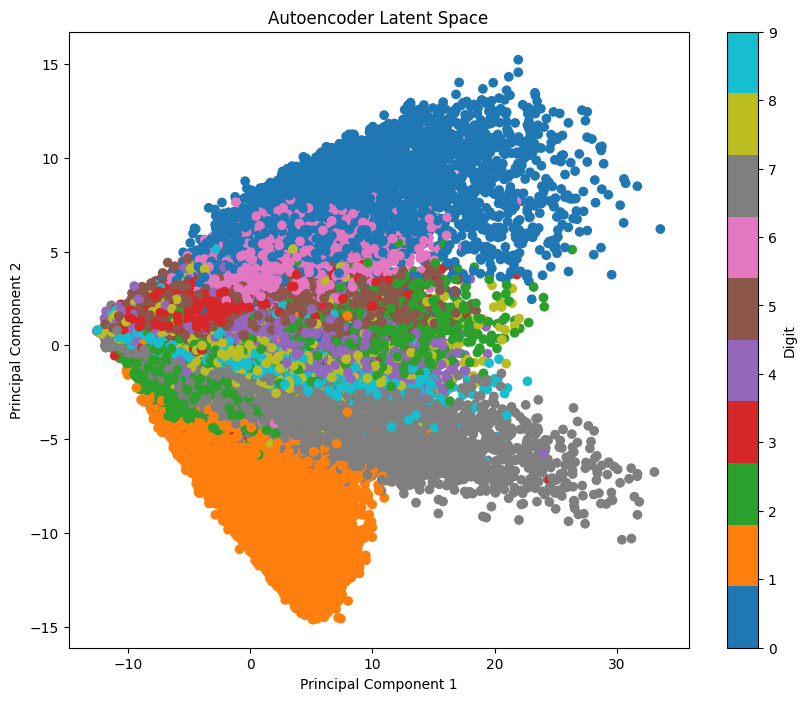

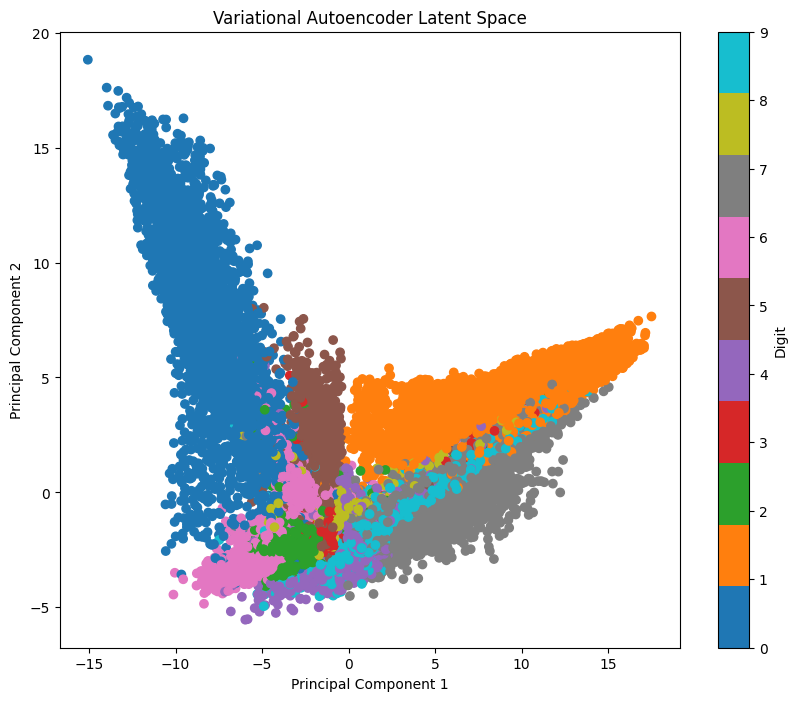

In [12]:
import numpy as np
from sklearn.decomposition import PCA

def plot_latent_space(encoder, data_loader, title):
    latent_vectors = []
    labels = []

    for inputs, targets in data_loader:
        inputs = inputs.view(inputs.size(0), -1)
        # Handle the case where the encoder returns only one tensor
        if isinstance(encoder(inputs), tuple):
            latent_mean, _ = encoder(inputs)
        else:
            latent_mean = encoder(inputs)
        latent_vectors.append(latent_mean.detach().numpy())
        labels.append(targets.numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)

    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10')
    plt.colorbar(label='Digit')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Plot latent space for Autoencoder
plot_latent_space(model_ae.encoder, train_dl, "Autoencoder Latent Space")

# Plot latent space for Variational Autoencoder
plot_latent_space(model_vae.encoder, train_dl, "Variational Autoencoder Latent Space")


## Part 2 : GANs


In [13]:
pip install opendatasets

In [14]:
import pandas as pd
import os
import opendatasets as od

In [15]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/bryanb/abstract-art-gallery'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohcineboudenjal
Your Kaggle Key: ··········


100%|██████████| 693M/693M [00:32<00:00, 22.1MB/s]


In [16]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [17]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [18]:
DATA_DIR = './abstract-art-gallery/Abstract_gallery/'
print(os.listdir(DATA_DIR))

['Abstract_gallery']


In [19]:
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_image_502.jpg', 'Abstract_image_1495.jpg', 'Abstract_image_921.jpg', 'Abstract_image_1968.jpg', 'Abstract_image_2302.jpg', 'Abstract_image_1602.jpg', 'Abstract_image_2441.jpg', 'Abstract_image_2558.jpg', 'Abstract_image_1967.jpg', 'Abstract_image_1354.jpg']


In [20]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_xticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


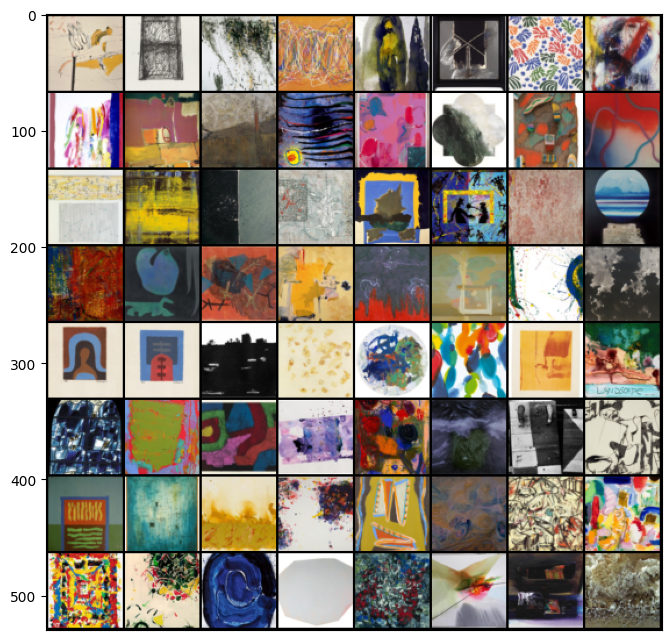

In [23]:
show_batch(train_dl)

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)

In [27]:
import torch.nn as nn

In [28]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

latent_size = 128

In [29]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


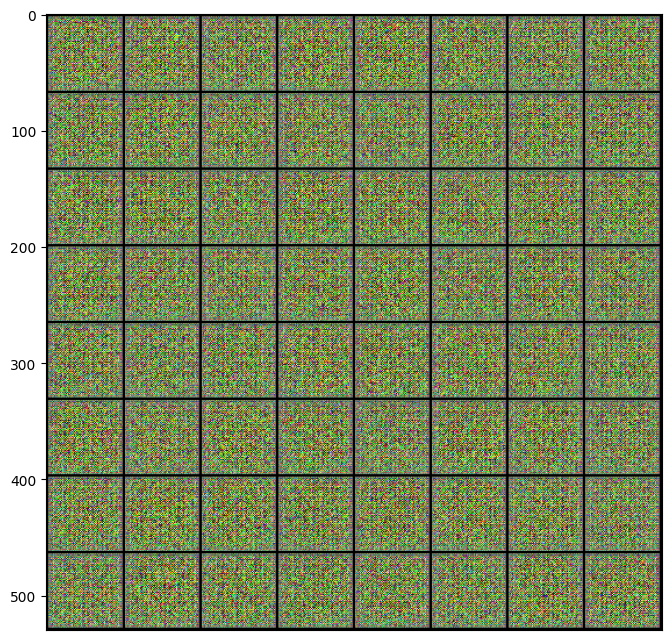

In [30]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [31]:
generator = to_device(generator, device)

In [32]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [33]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [34]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [35]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [36]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [37]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [38]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [39]:
lr = 0.0002
epochs = 25

In [40]:
history = fit(epochs, lr)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.3494, loss_d: 0.3689, real_score: 0.7650, fake_score: 0.0803
Saving generated-images-0001.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 6.7170, loss_d: 0.6127, real_score: 0.8165, fake_score: 0.3151
Saving generated-images-0002.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.5447, loss_d: 0.2426, real_score: 0.9675, fake_score: 0.1852
Saving generated-images-0003.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.4457, loss_d: 0.2589, real_score: 0.7931, fake_score: 0.0054
Saving generated-images-0004.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.5709, loss_d: 0.2393, real_score: 0.9262, fake_score: 0.1456
Saving generated-images-0005.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 3.8296, loss_d: 0.0777, real_score: 0.9694, fake_score: 0.0451
Saving generated-images-0006.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.4910, loss_d: 0.2656, real_score: 0.8964, fake_score: 0.1370
Saving generated-images-0007.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.4056, loss_d: 0.1336, real_score: 0.9234, fake_score: 0.0499
Saving generated-images-0008.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.5115, loss_d: 0.2433, real_score: 0.9272, fake_score: 0.1500
Saving generated-images-0009.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 3.0649, loss_d: 0.2254, real_score: 0.9089, fake_score: 0.1163
Saving generated-images-0010.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.2189, loss_d: 0.1440, real_score: 0.9055, fake_score: 0.0388
Saving generated-images-0011.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.5886, loss_d: 0.2300, real_score: 0.9441, fake_score: 0.1096
Saving generated-images-0012.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.5121, loss_d: 0.1895, real_score: 0.8624, fake_score: 0.0203
Saving generated-images-0013.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.8374, loss_d: 0.3697, real_score: 0.7523, fake_score: 0.0391
Saving generated-images-0014.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.3182, loss_d: 0.7081, real_score: 0.5948, fake_score: 0.0060
Saving generated-images-0015.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 2.8741, loss_d: 0.6108, real_score: 0.7741, fake_score: 0.2553
Saving generated-images-0016.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 1.6736, loss_d: 0.8024, real_score: 0.7292, fake_score: 0.2821
Saving generated-images-0017.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 2.6062, loss_d: 0.4616, real_score: 0.7845, fake_score: 0.1658
Saving generated-images-0018.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 1.6801, loss_d: 0.5090, real_score: 0.7194, fake_score: 0.1081
Saving generated-images-0019.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 2.6464, loss_d: 0.6308, real_score: 0.7411, fake_score: 0.2295
Saving generated-images-0020.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 6.1138, loss_d: 0.8130, real_score: 0.9153, fake_score: 0.4471
Saving generated-images-0021.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.4601, loss_d: 0.4475, real_score: 0.8010, fake_score: 0.1717
Saving generated-images-0022.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.3405, loss_d: 0.5576, real_score: 0.8817, fake_score: 0.3167
Saving generated-images-0023.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.0193, loss_d: 0.6252, real_score: 0.8990, fake_score: 0.3628
Saving generated-images-0024.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 7.2366, loss_d: 0.9113, real_score: 0.9330, fake_score: 0.5192
Saving generated-images-0025.png


In [41]:
losses_g, losses_d, real_scores, fake_scores = history

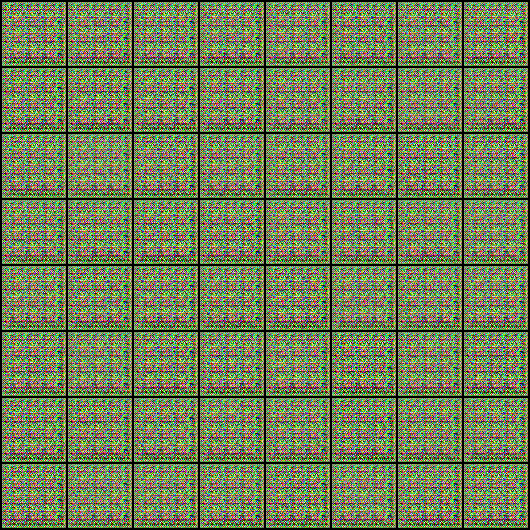

In [42]:
from IPython.display import Image

Image('./generated/generated-images-0001.png')


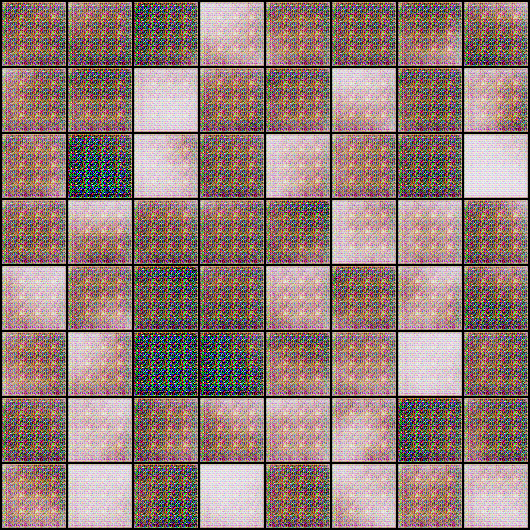

In [43]:
Image('./generated/generated-images-0005.png')


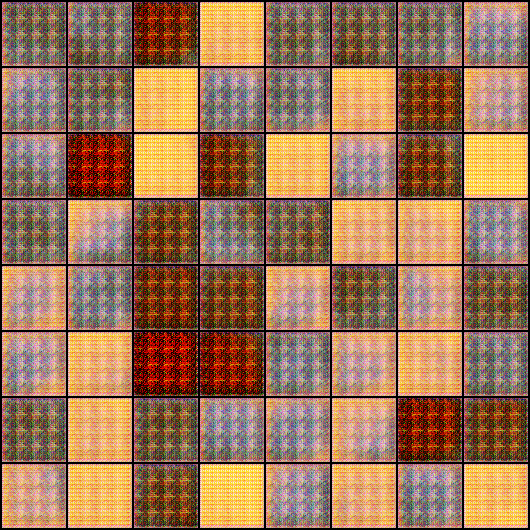

In [44]:
Image('./generated/generated-images-0010.png')


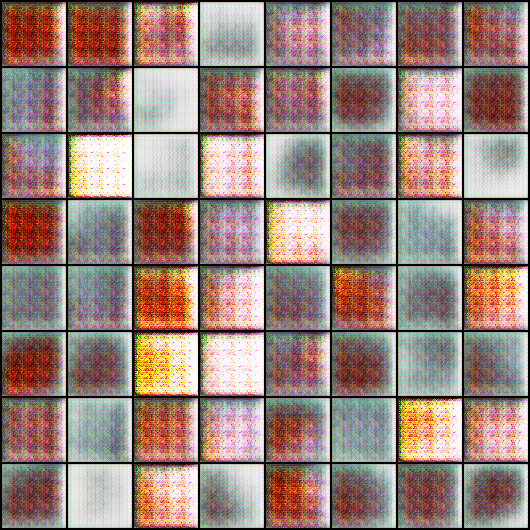

In [45]:
Image('./generated/generated-images-0015.png')


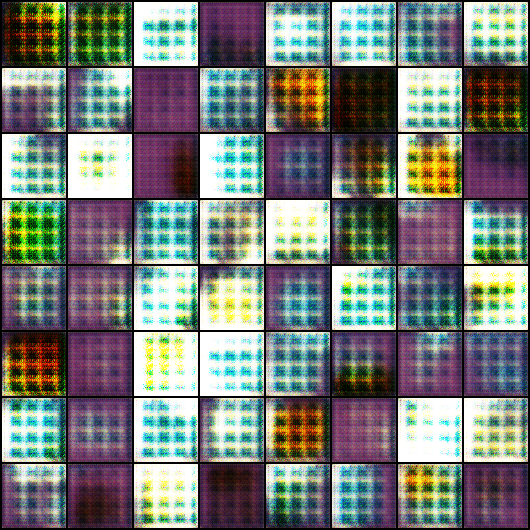

In [46]:
Image('./generated/generated-images-0025.png')

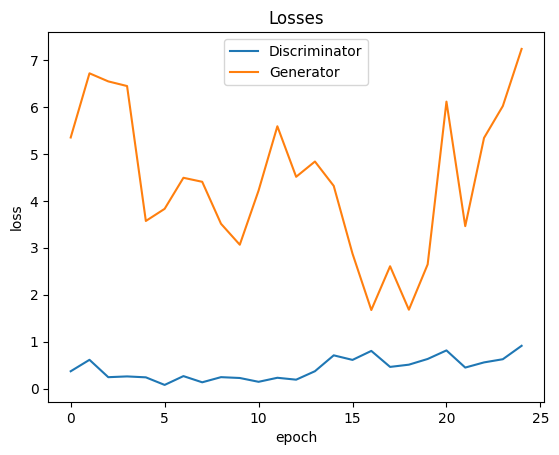

In [47]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

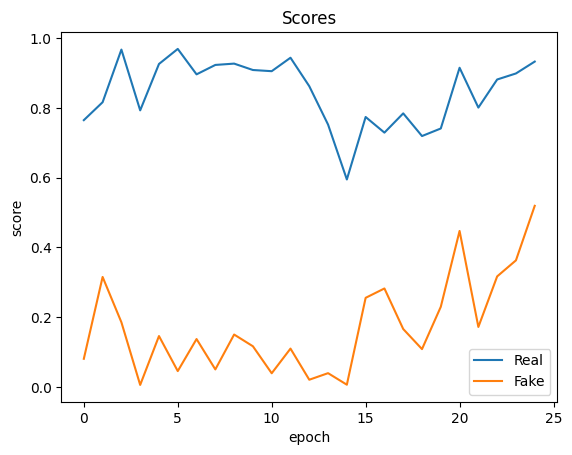

In [48]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### Conclusion
The training of the GAN resulted in fluctuating losses over 25 epochs, indicating some instability in the process. However, the discriminator effectively distinguished between real and fake images throughout. Further optimization may be needed to improve stability and image quality.